## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

camera_cal/calibration2.jpg
True


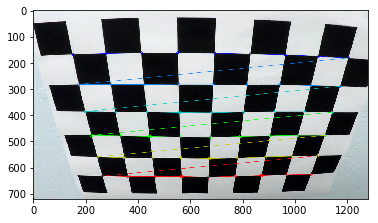

camera_cal/calibration3.jpg
True


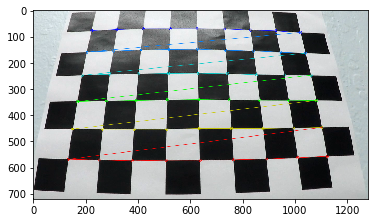

camera_cal/calibration4.jpg
False
camera_cal/calibration5.jpg
False
camera_cal/calibration6.jpg
True


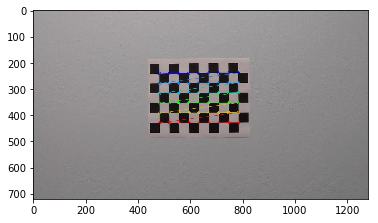

camera_cal/calibration7.jpg
True


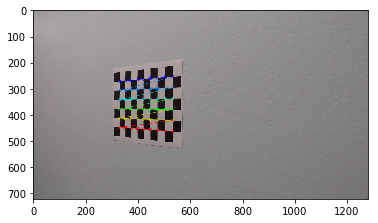

camera_cal/calibration8.jpg
True


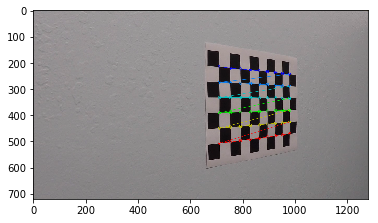

camera_cal/calibration9.jpg
True


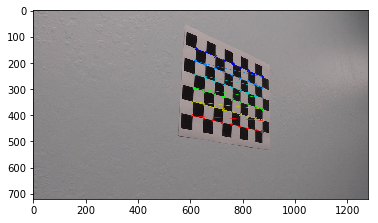

camera_cal/calibration10.jpg
True


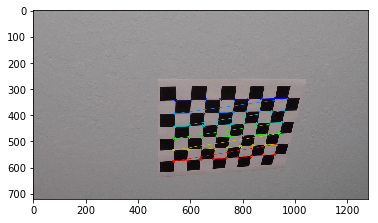

camera_cal/calibration11.jpg
True


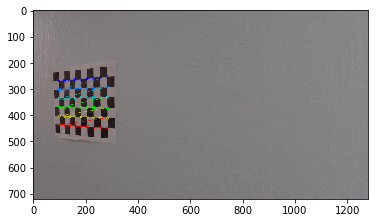

camera_cal/calibration12.jpg
True


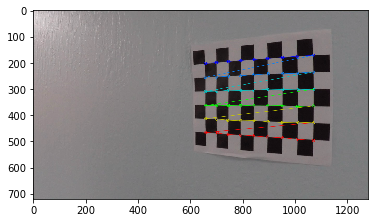

camera_cal/calibration13.jpg
True


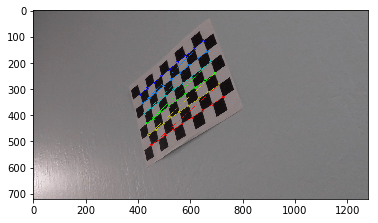

camera_cal/calibration14.jpg
True


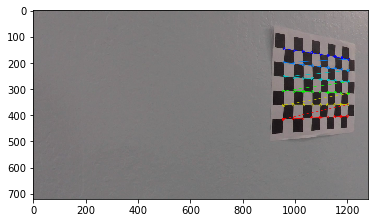

camera_cal/calibration15.jpg
True


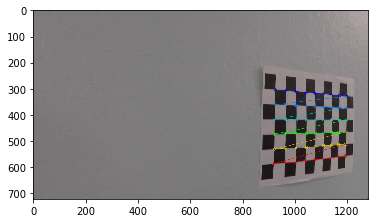

camera_cal/calibration16.jpg
True


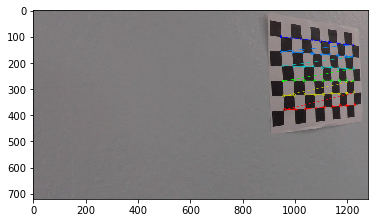

camera_cal/calibration17.jpg
True


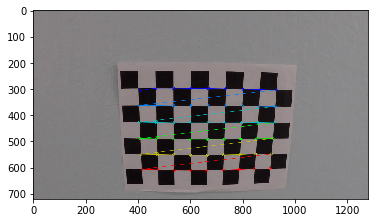

camera_cal/calibration18.jpg
True


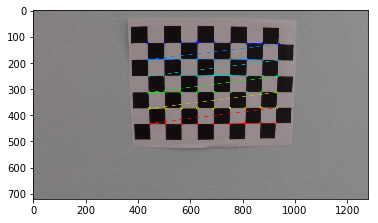

camera_cal/calibration19.jpg
True


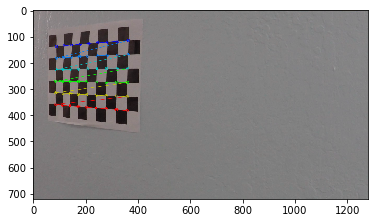

camera_cal/calibration20.jpg
True


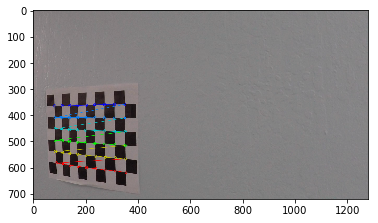

the test image and undistorted test image


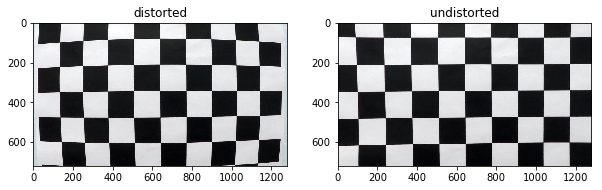

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

def get_cal_para():
    '''
    to get the parameters of the calibration
    '''
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    # Make a list of calibration images
    images_cal = []
    for i in range(2, 21):
        images_cal.append('camera_cal/calibration'+str(i)+'.jpg')
    # Use the fist pic for test
    images_test = cv2.imread('camera_cal/calibration1.jpg')
    # Step through the list and search for chessboard corners
    for image in images_cal:
        print(image)
        img = cv2.imread(image)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
        print(ret)
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            cv2.drawChessboardCorners(img, (9,6), corners, ret)
            #show the image
            plt.imshow(img)
            plt.show()
            
    img_size = (images_test.shape[1],images_test.shape[0])
    # Get the parameters
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    # Undistort the test image
    undist = cv2.undistort(images_test, mtx, dist, None, mtx)
    #Show the test image
    print('the test image and undistorted test image')
    plt.figure(2, figsize=(10,10))
    plt.subplot(1, 2,1)
    plt.title('distorted')
    plt.imshow(images_test)
    plt.subplot(1, 2,2)
    plt.title('undistorted')
    plt.imshow(undist)

    return cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)



#get the parameter of the calibration
ret, mtx, dist, rvecs, tvecs = get_cal_para()

## Second, get the pixels of lane lines and perspective transform the image

* use gray,S and V thresholds to get the lane lines
* warp the image

In [2]:
def warpImg(img, S_thresh=(120,255), Gradx_thresh=(20,200), src=np.float32([[593,450],[685,450],[1117,719],[194,719]]),
              dst=np.float32([[290,0],[990,0],[990,719],[290,719]]),showpic=True):
    '''
    something
    '''
    #Ensure the thresh is resonable
    assert S_thresh[0] < S_thresh[1]
    assert Gradx_thresh[0] < Gradx_thresh[1]
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #Convert image to gray
    S_img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)[:, :, 2] #Get the S channel
    V_img=cv2.cvtColor(img, cv2.COLOR_BGR2HSV)[:,:,2] #Get the V channel
    
    #sobel x
    gradx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0)) #Take the derivative in x
    scale_gradx = np.uint8(255*gradx/np.max(gradx)) #scale the x derivation to 0~255
    
    # Threshold x grad
    bin_gradx = np.zeros_like(scale_gradx)
    bin_gradx[(scale_gradx>=Gradx_thresh[0])&(scale_gradx<=Gradx_thresh[1])] = 1
    
    # Threshold S channel
    bin_S = np.zeros_like(S_img)
    bin_S[(S_img>=S_thresh[0])&(S_img<=S_thresh[1])] = 1
    
    # Threshold V channel
    bin_V=np.zeros_like(V_img)
    bin_V[(V_img>130)&(V_img<255)]=1
    
    # Combine the three binary thresholds
    bin_comb = np.zeros_like(bin_S)
    bin_comb = bin_V+bin_S+bin_gradx
    bin_comb[bin_comb<1.5]=0
    bin_comb[bin_comb>1.5]=1
    
    yy, xx = bin_comb.shape
    
    # Mask
    top_left_ratio = [0.48, 0.58]
    top_right_ratio = [0.55, 0.58]
    bottom_left_ratio = [0.12, 1]
    bottom_right_ratio = [0.93, 1]
    #calc out vertices
    top_left = (top_left_ratio[0]*xx, top_left_ratio[1]*yy)
    top_right = (top_right_ratio[0]*xx, top_right_ratio[1]*yy)
    bottom_left = (bottom_left_ratio[0]*xx, bottom_left_ratio[1]*yy)
    bottom_right = (bottom_right_ratio[0]*xx, bottom_right_ratio[1]*yy)
    vertices = np.array([[top_left, top_right, bottom_right, bottom_left]], dtype=np.int32)
    
    mask = np.zeros_like(bin_comb)
    cv2.fillPoly(mask, vertices, 1)
    masked_comb =bin_comb*mask
    
    # Geet the perspective trasform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the masked image
    warped = cv2.warpPerspective(masked_comb, M, (xx,yy), flags=cv2.INTER_LINEAR)
    
    #show the warped image
    if showpic:
        plt.figure(figsize=(16,7))
        plt.subplot(1,2,1)
        plt.imshow(bin_comb,cmap='gray')
        plt.subplot(1,2,2)
        plt.imshow(warped,cmap='gray')
        
    return warped

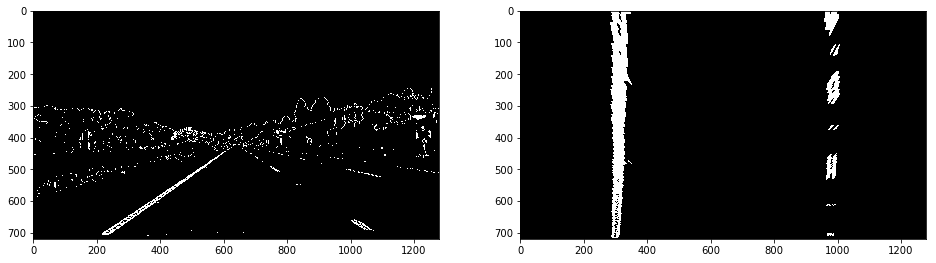

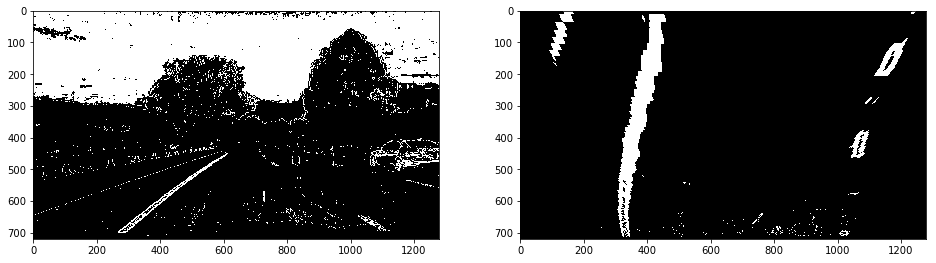

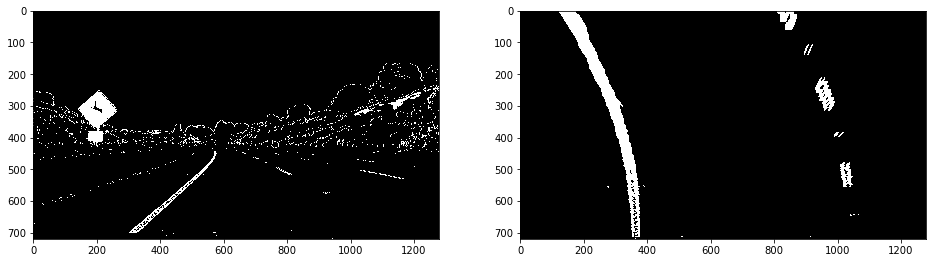

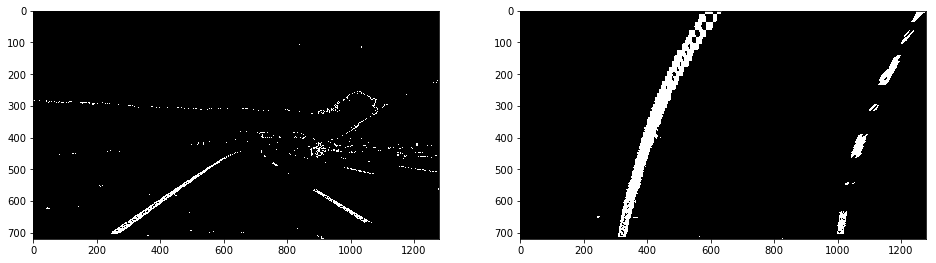

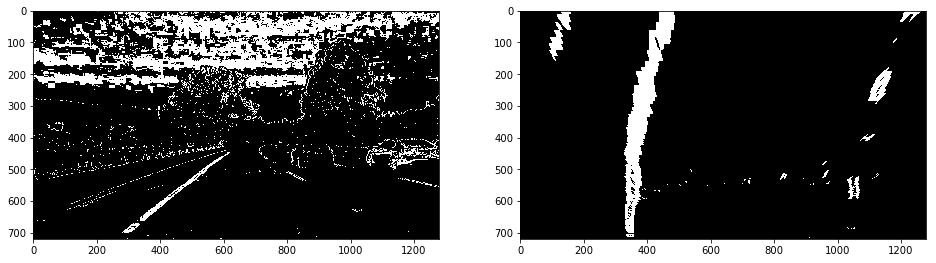

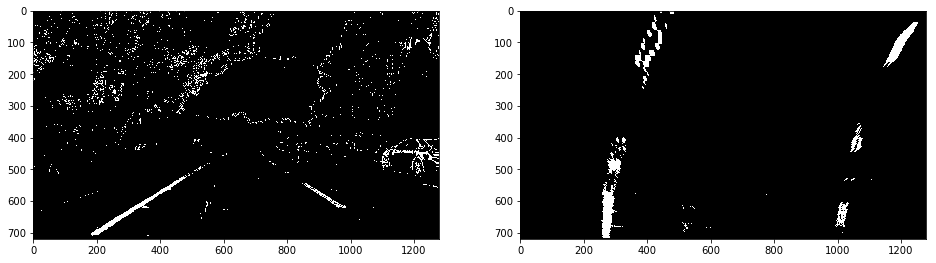

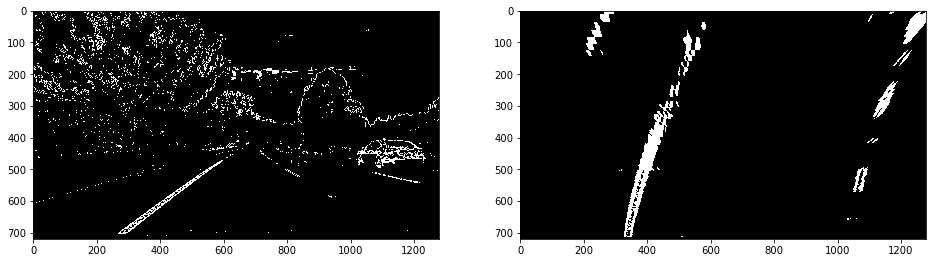

In [3]:
# test the function with test images
testimg = cv2.undistort(cv2.imread('test_images/straight_lines1.jpg'), mtx, dist, None, mtx)
warped = warpImg(testimg)
for i in range(1,7):
    testimg = cv2.undistort(cv2.imread('test_images/test'+str(i)+'.jpg'), mtx, dist, None, mtx)
    warped = warpImg(testimg)


###  Thrid, make the Line class

In [4]:
import numpy as np
import matplotlib.pyplot as plt



class Line():
    '''
    '''
    n_frame = 8 # The number of last n frame
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = None
        #radius of curvature of the line in some units
        self.radius_of_curvature = None
        #distance in meters of vehicle center from the line
        self.line_base_pos = None
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None
        #y values for detected line pixels
        self.ally = None
        # x values of this fit of the line
        self.current_xfitted = None
        
        self.num_box = 9
        self.box_width = 180
        # the image to show
        self.out_img = None
        #The y use for polyfit
        self.y_range = None
        #The boxes used to find lane line pixels
        self.boxes = []
    
    def histogram(self, img):
        '''
        This metohd to get histogram along all the columns in the lower quarter of the image
        '''
        return np.sum(img[img.shape[0]*3//4:,:], axis=0)

    def __dealbox(self,ind,box=[1,2,0,3]):
        '''
        This method to find the center of the pixels in box
        ind = index
        box=[left, right, top, bott]
        '''
        assert box[1]>box[0]
        assert box[3]>box[2]

        xx=ind[1]
        yy=ind[0]
        inbox_index = ((xx>=box[0])&(xx<=box[1])&(yy>=box[2])&(yy<=box[3])).nonzero()
        
        # If the number of pixels found in box is more than 100, then get the center of the pixels
        if len(xx[inbox_index])>100:
            centerpoint = [np.int(np.average(xx[inbox_index])), np.int(np.average(yy[inbox_index]))]
        else:
            centerpoint = [-1, -1]
        return centerpoint

    def findlinepoints(self, img, isleft=True, last_n_Lines=[]):
        '''
        This method to find line in img
        "Isleft" means to get the left or right line
        '''
        self.out_img = np.dstack((img, img, img))*255
        self.allx = []
        self.ally = []
        self.y_range = np.linspace(0,img.shape[0]-1,img.shape[0]) # y for calculating x
        img_nonzero = img.nonzero()
        box_hight = img.shape[0]/self.num_box

        #if is the first frame
        if len(last_n_Lines) < 1:
            mid = img.shape[1]//2
            histogram = self.histogram(img)
            
            #Get the center of first box use histogram method
            if isleft:
                x_start = np.argmax(histogram[:mid])
            else:
                x_start = np.argmax(histogram[mid:])+mid

            for i in range(self.num_box, 0, -1):
                # The box position
                box_top = box_hight*(i-1)
                box_bott = box_hight*i
                box_left = x_start - self.box_width/2
                box_right = x_start + self.box_width/2
                # Stor the boxes
                self.boxes.append([box_left, box_right, box_top, box_bott])
                # Get the center point in box use the method dealbox
                center_point = self.__dealbox(img_nonzero, self.boxes[-1])
                # Update the allx,ally and x_start
                if center_point[0] > 0:
                    self.allx.append(center_point[0])
                    self.ally.append(center_point[1])
                    x_start = center_point[0]
                    
            # If I get center points more than 2, means i detected line
            if len(self.allx) >= 3:
                self.detected = True
                self.__polyfit()
                # The best fit and x just copy current fit and x
                self.best_fit = self.current_fit
                self.bestx = self.current_xfitted
            else:
                self.detected =False
                
        #if is not the fistr frame
        else: 
            # Use last farme box to be the start x
            box = last_n_Lines[-1].boxes[0]
            x_start = (box[0]+box[1])/2
            for i in range(self.num_box, 0, -1):
                box_top = box_hight*(i-1)
                box_bott = box_hight*i
                box_left = x_start - self.box_width/2
                box_right = x_start + self.box_width/2
                # Stor the boxes
                self.boxes.append([box_left, box_right, box_top, box_bott])
                # Get the center point in box use the method dealbox
                center_point = self.__dealbox(img_nonzero, self.boxes[-1])
                # Update the allx,ally and x_start
                if center_point[0] > 0:
                    self.allx.append(center_point[0])
                    self.ally.append(center_point[1])
                    x_start = center_point[0]

            if len(self.allx) >= 3:
                self.detected = True
                self.__polyfit()
                # Update the recent_xfitted
                for a_line in last_n_Lines:
                    self.recent_xfitted.append(a_line.current_xfitted)
                self.recent_xfitted.append(self.current_xfitted)
                # Get the average x
                aver_x = np.average(self.recent_xfitted,axis=0)
                # Best fit
                self.best_fit = np.polyfit(self.y_range, aver_x, 2)
                self.bestx = self.best_fit[0]*self.y_range**2 + self.best_fit[1]*self.y_range + self.best_fit[2]
        # Measuring curvature
        if self.detected:
            self.calc_radius()                 

    def __polyfit(self):
        '''
        This metohd to calculate the current fit and xfitted
        '''
        if self.detected:
            self.current_fit = np.polyfit(self.ally, self.allx, 2)
            self.current_xfitted = self.current_fit[0]*self.y_range**2 + self.current_fit[1]*self.y_range + self.current_fit[2]
    
    def calc_radius(self, ym_per_pix=30/720,xm_per_pix=3.7/700):
        '''
        # This method to measure curvature
        '''
        fit_cr = np.polyfit(self.y_range*ym_per_pix, self.bestx*xm_per_pix, 2)
        self.radius_of_curvature = ((1+(2*fit_cr[0]*np.max(self.y_range)*ym_per_pix + fit_cr[1])**2)**1.5)/np.abs(2*fit_cr[0])
        return self.radius_of_curvature
    
    @staticmethod
    def check_lines(left, right):
        '''
        check the left and right lines
        '''
        if left.detected & right.detected:
            width = right.bestx-left.bestx
            # If the right and left is crossed
            if np.sum(width<0)>0:
                left.detected = False
                right.detected = False
            else:# If the right and left is not crossed
                delta = (np.max(width)-np.min(width))/np.average(width)
                if delta>0.35:
                    left.detected = False
                    right.detected = False
    
    @staticmethod
    def center_of_two_lines(left,right):
        '''
        get the right and left line center
        '''
        if left.detected & right.detected:
            return (left.bestx[-1]+right.bestx[-1])/2
    
    
    def show_img(self, color_box='y', color_cur=(255,0,0)):
        # Show the image for my test
        plt.figure(figsize=(6,5))
        points = np.transpose(np.vstack((self.bestx, self.y_range)))
        points = np.array(points, np.int32)
        img = cv2.polylines(self.out_img, [points], False, color_cur, 8)
        plt.imshow(img)
        for box in self.boxes:
            xx = [box[0], box[1], box[1], box[0], box[0]]
            yy = [box[2], box[2], box[3], box[3], box[2]]
            plt.plot(xx,yy, color=color_box)
            

### Test my line class

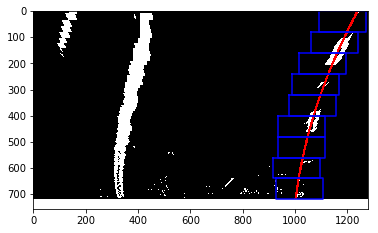

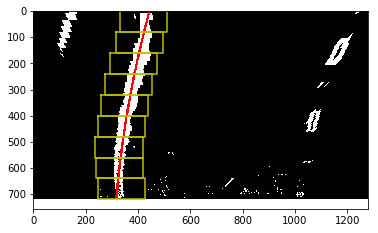

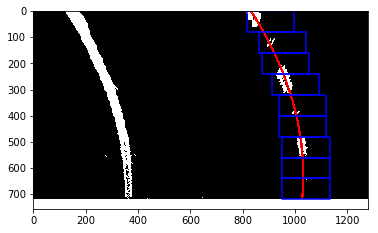

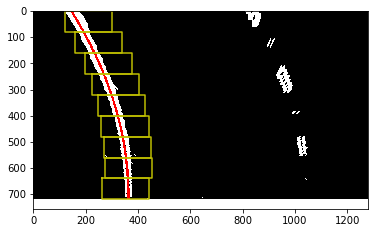

In [5]:
            
for i in range(1,3):
    testimg = cv2.undistort(cv2.imread('test_images/test'+str(i)+'.jpg'), mtx, dist, None, mtx)
    warped = warpImg(testimg,showpic = False)        
    a = Line()
    a.findlinepoints(warped, False,[])
    b = Line()
    b.findlinepoints(warped, True, [])
    
    a.show_img(color_box='b', color_cur=(255,0,0))
    b.show_img()


In [6]:




# The var for perspective matrix
src=np.float32([[593,450],[685,450],[1117,719],[194,719]])
dst=np.float32([[290,0],[990,0],[990,719],[290,719]])
            
def drawlines(undist, warped,line_left,line_right):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    left_points = np.transpose(np.vstack((line_left.bestx, line_left.y_range)))
    left_points = np.array([left_points], np.int32)
    right_points = np.transpose(np.vstack((line_right.bestx, line_right.y_range)))
    right_points = np.flipud(right_points)
    right_points = np.array([right_points], np.int32)
    pts = np.hstack((left_points, right_points))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    
    # Inverse perspective matrix 
    M_inv = cv2.getPerspectiveTransform(dst, src)
    
    # Warp the blank back to original image space
    newwarp = cv2.warpPerspective(color_warp, M_inv, (undist.shape[1], undist.shape[0]))
    img = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    # Get the average of left and right radias
    cur_radias = (line_left.radius_of_curvature + line_right.radius_of_curvature)/2
    
    # Left or right curve
    if line_left.best_fit[0]>=0:
        cur_direction = ' -->'
    else:
        cur_direction = ' <--'
    
    if cur_radias>2000: # If the radias is bigger than 2000 regard the curve as stright
        cur_direction=' <->'
        cur_radias = 0
    # Make the string of curve information
    radias_str = 'Cur:'+ cur_direction + '  Radias: '+str(round(cur_radias,1))+'(m)'
    
    #Offset
    center_x = Line.center_of_two_lines(line_left,line_right)
    img_mid = undist.shape[1]/2
    center_offset = (center_x-img_mid)*3.7/700
    if center_offset >=0:
        center_dir = ' -->'
    else:
        center_dir = ' <--'
    # Make the string of offset information
    center_str = 'Off:'+center_dir +'  Dis: '+str(round(np.abs(center_offset), 2))+'(m)'
    
    # Put string on image
    cv2.putText(img, radias_str, (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 3)
    cv2.putText(img, center_str, (10, 105), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 3)
    return img

def process_frame(img):
    # Undistort the frame
    img = cv2.undistort(img, mtx, dist, None, mtx) #Distortion correction
    # Get the line pixels and warp the frame
    warped = warpImg(img, showpic=False)
    # Get the line in warped frame
    lef_line = Line()
    lef_line.findlinepoints(warped, isleft=True, last_n_Lines=left_lines)
    rig_line = Line()
    rig_line.findlinepoints(warped, isleft=False, last_n_Lines=right_lines)
    # Check the left and right line
    Line.check_lines(lef_line, rig_line)
    
    # If is the first frame
    if len(left_lines) == 0:
        if lef_line.detected & rig_line.detected:
            left_lines.append(lef_line)
            right_lines.append(rig_line)
    # If is not the first frame
    else:
        # If detected then store in list else just copy last line
        if lef_line.detected:
            left_lines.append(lef_line)
        else:
            left_lines.append(left_lines[-1])
        if rig_line.detected:
            right_lines.append(rig_line)
        else:
            right_lines.append(right_lines[-1])
    # keep the length of the list as n_frame
    if len(left_lines) > Line.n_frame:
        del left_lines[0]
        del right_lines[0]
    # Draw lines and string in frame
    if len(left_lines)>0:
        frame = drawlines(img,warped,left_lines[-1], right_lines[-1])
        return frame
    else:
        return warp



### Test my process_frame

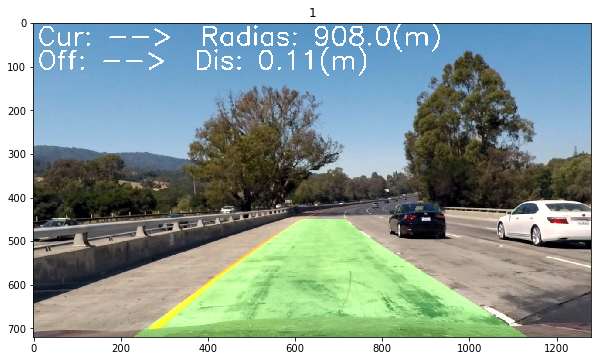

In [7]:
left_lines=[] # Store the last n frame left lines
right_lines=[] # Store the n frame right lines

a=process_frame(cv2.imread('test_images/test1.jpg'))

plt.figure(figsize=(10,7))
plt.title('1')
plt.imshow(cv2.cvtColor(a, cv2.COLOR_BGR2RGB))

left_lines=[]
right_lines=[]


## Forth, deal the video

In [8]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_frame) #NOTE: this function expects color images!!
%time white_clip.write_videofile('video_out.mp4', audio=False)
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('video_out.mp4'))


[MoviePy] >>>> Building video video_out.mp4
[MoviePy] Writing video video_out.mp4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [02:43<00:00,  7.99it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video_out.mp4 

Wall time: 2min 44s
